In [1]:
import pathlib as pl
import shutil
import dakota.environment as dakenv
import sys, os
import numpy as np

# script_dir = pl.Path(__file__).parent
script_dir = pl.Path(os.getcwd())  ## how resilient is this?
print(script_dir)
sys.path.append(script_dir)

from utils import funs_create_dakota_conf, funs_data_processing

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation


In [2]:
data_dir = script_dir / "Norm20D"
TRAINING_SAMPLES_FILE = data_dir / "train_Norm20D_1000LHS.dat"
TEST_SAMPLES_FILE = data_dir / "test_Norm20D_100LHS.dat"

## Load & process input data

In [3]:
tmp_folder = script_dir / ".tmp_output"
if tmp_folder.exists():
    shutil.rmtree(tmp_folder)
tmp_folder.mkdir()
TRAINING_SAMPLES_FILE = shutil.copy(TRAINING_SAMPLES_FILE, tmp_folder)
TEST_SAMPLES_FILE = shutil.copy(TEST_SAMPLES_FILE, tmp_folder)

In [4]:
PROCESSED_TRAINING_FILE = funs_data_processing.process_input_file(TRAINING_SAMPLES_FILE)
PROCESSED_TEST_FILE = funs_data_processing.process_input_file(
    TEST_SAMPLES_FILE,
    columns_to_remove=[
        "interface",
        "AFmax_4um",
        "GAFmax_4um",
    ],  # remove the output column; needs to be evaluated
)

In [5]:
variables_train = funs_data_processing.get_variable_names(PROCESSED_TRAINING_FILE)
print(variables_train)
variables_test = funs_data_processing.get_variable_names(PROCESSED_TEST_FILE)
print(variables_test)

['%eval_id', 'RELDEPTH', 'DIAMETER', 'ANGLE', 'ELECTRELDEPTH', 'THICKNESS_SKIN', 'THICKNESS_SCT', 'THICKNESS_APONEUROSIS', 'THICKNESS_LOOSE_AREOLAR_TISSUE', 'THICKNESS_SKULL_OUTER', 'THICKNESS_SKULL_DIPLOE', 'THICKNESS_SKULL_INNER', 'THICKNESS_CSF', 'CONDUCTIVITY_SKIN', 'CONDUCTIVITY_SCT', 'CONDUCTIVITY_APONEUROSIS', 'CONDUCTIVITY_LOOSE_AREOLAR_TISSUE', 'CONDUCTIVITY_SKULL_CORTICAL', 'CONDUCTIVITY_SKULL_DIPLOE', 'CONDUCTIVITY_CSF', 'AFmax_4um', 'GAFmax_4um']
['%eval_id', 'RELDEPTH', 'DIAMETER', 'ANGLE', 'ELECTRELDEPTH', 'THICKNESS_SKIN', 'THICKNESS_SCT', 'THICKNESS_APONEUROSIS', 'THICKNESS_LOOSE_AREOLAR_TISSUE', 'THICKNESS_SKULL_OUTER', 'THICKNESS_SKULL_DIPLOE', 'THICKNESS_SKULL_INNER', 'THICKNESS_CSF', 'CONDUCTIVITY_SKIN', 'CONDUCTIVITY_SCT', 'CONDUCTIVITY_APONEUROSIS', 'CONDUCTIVITY_LOOSE_AREOLAR_TISSUE', 'CONDUCTIVITY_SKULL_CORTICAL', 'CONDUCTIVITY_SKULL_DIPLOE', 'CONDUCTIVITY_CSF']


## Plot input data (Fig03 & Fig07)

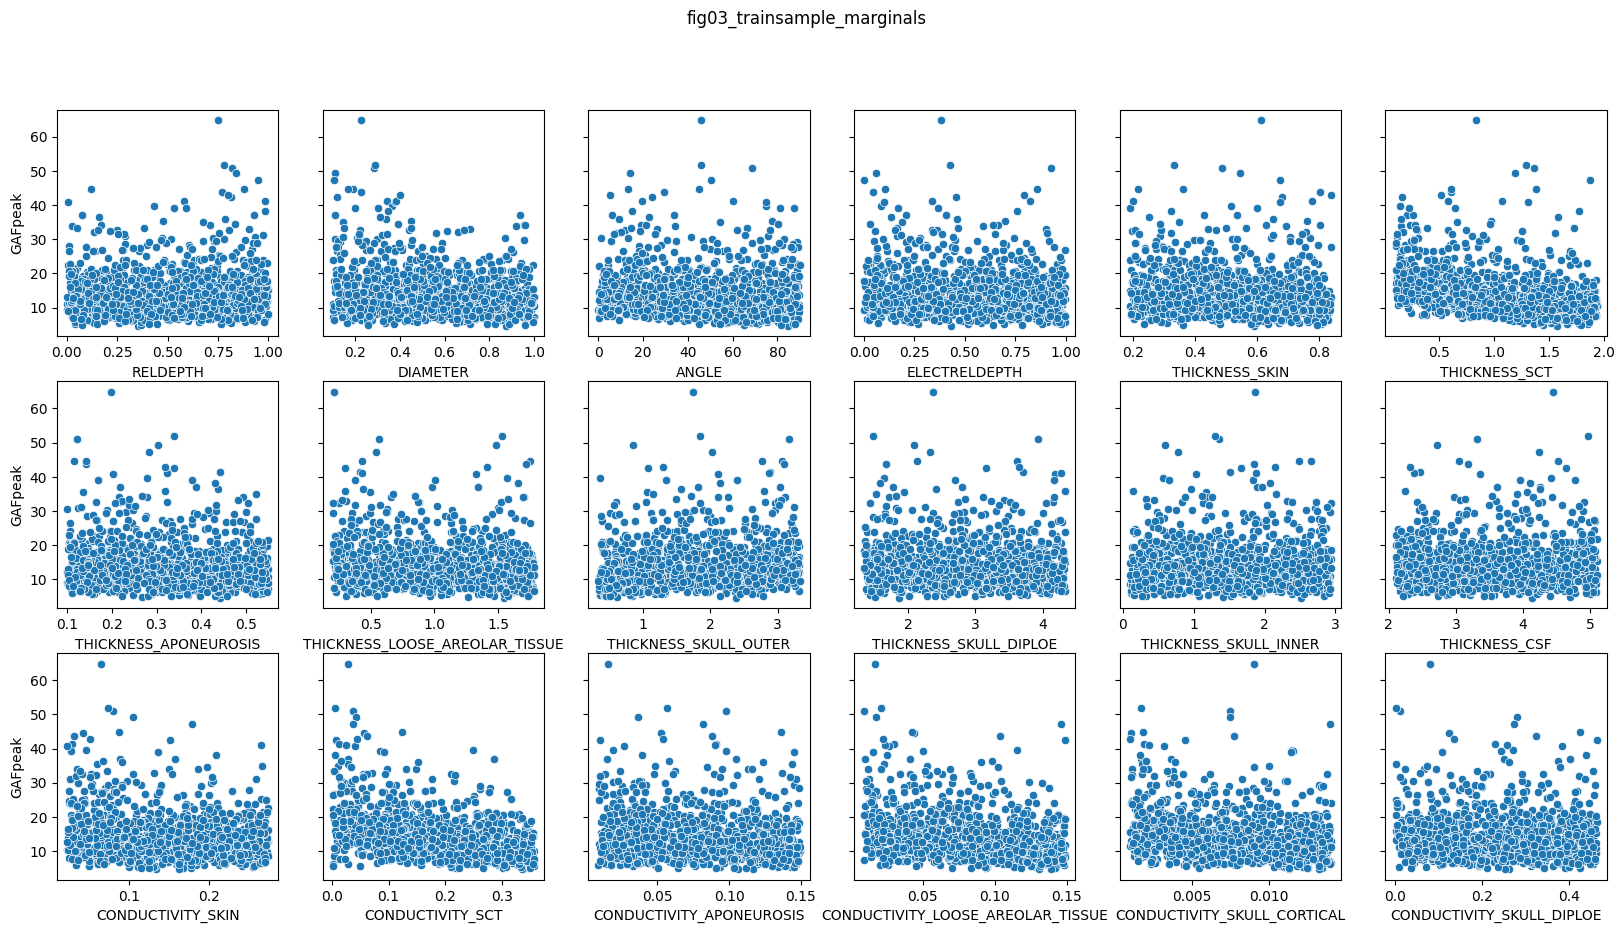

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

title = "fig03_trainsample_marginals"
fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
data = funs_data_processing.load_data(PROCESSED_TRAINING_FILE)
data = data.astype(np.float64)
data.rename(columns={"GAFmax_4um": "GAFpeak"}, inplace=True)
data.head()
axs: List[plt.Axes] = axs.flatten()
# fig, axs = plt.subplots(1,1, figsize=(15, 15), sharey=True)
# axs = [axs]
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="GAFpeak", ax=ax)
    # plt.scatter(data[c].values, data["AFpeak"].values)
    ax.set_xlabel(c)
    # ax.hlines(0.0, data[c].min(), data[c].max(), color="black", linestyle="--")
plt.suptitle(title)
plt.show()

## Create & run Dakota study

In [11]:
N_RESPONSES = 2

dakota_conf_path = tmp_folder / "dakota.in"
dakota_conf = funs_create_dakota_conf.start_dakota_file()
dakota_conf += funs_create_dakota_conf.add_surrogate_model(
    PROCESSED_TRAINING_FILE,
    cross_validation_folds=None,
)
dakota_conf += funs_create_dakota_conf.add_evaluation_method(
    PROCESSED_TEST_FILE, includes_eval_id=True
)
dakota_conf += funs_create_dakota_conf.add_variables(
    variables=variables_train[1:-N_RESPONSES],
)
dakota_conf += funs_create_dakota_conf.add_responses(variables_train[-N_RESPONSES:])
print(dakota_conf)
funs_create_dakota_conf.write_to_file(dakota_conf, dakota_conf_path)


    environment
        tabular_data
            tabular_data_file = 'results.dat'
    

        model
            id_model 'SURR_MODEL'
            surrogate global
                gaussian_process surfpack
                ## hopefully faster by removing CV
                import_build_points_file 
                    '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output/train_Norm20D_1000LHS_processed.txt'
                    custom_annotated header eval_id
                export_approx_points_file "predictions.dat"
                export_approx_variance_file "variances.dat"
        
        method
            id_method "EVALUATION"
            output debug
            model_pointer 'SURR_MODEL'
        
            list_parameter_study
                import_points_file 
                    ## this file should be wo responses!!
                    '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.t

In [10]:
N_RESPONSES = 2

dakota_conf_path = tmp_folder / "dakota.in"
dakota_conf = funs_create_dakota_conf.start_dakota_file()
dakota_conf += funs_create_dakota_conf.add_surrogate_model(
    PROCESSED_TRAINING_FILE, cross_validation_folds=5
)
dakota_conf += funs_create_dakota_conf.add_evaluation_method(PROCESSED_TEST_FILE)
dakota_conf += funs_create_dakota_conf.add_variables(
    variables=variables_train[1:-N_RESPONSES],
)
dakota_conf += funs_create_dakota_conf.add_responses(variables_train[-N_RESPONSES:])
print(dakota_conf)
funs_create_dakota_conf.write_to_file(dakota_conf, dakota_conf_path)


    environment
        tabular_data
            tabular_data_file = 'results.dat'
    

        model
            id_model 'SURR_MODEL'
            surrogate global
                gaussian_process surfpack
                
                cross_validation folds = 5 
                metrics = "root_mean_squared" "sum_abs" "mean_abs" "max_abs" "rsquared"
                
                import_build_points_file 
                    '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output/train_Norm20D_1000LHS_processed.txt'
                    custom_annotated header eval_id
                export_approx_points_file "predictions.dat"
                export_approx_variance_file "variances.dat"
        
        method
            id_method "EVALUATION"
            output debug
            model_pointer 'SURR_MODEL'
        
            list_parameter_study
                import_points_file 
                    ## this file should be wo respons

In [12]:
os.chdir(tmp_folder)
shutil.copy(script_dir / "execute_dakota.py", tmp_folder)
!python execute_dakota.py
os.chdir(script_dir)

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output
Dakota version 6.19+ (stable) released Aug  8 2024.
Repository revision 494027b (2024-04-29) built Aug  8 2024 14:37:02.
Running serial Dakota executable in serial mode.
Start time: Tue Sep 17 17:04:10 2024

Using provided Dakota input string
Writing new restart file 'dakota.rst'.
Surrogate model retrieving points with 19 variables and 2 response
functions from file '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output/train_Norm20D_1000LHS_processed.txt'
Variables read:
                      5.2840907790e-02 RELDEPTH
                      9.9312249720e-01 DIAMETER
                      6.3815589090e+00 ANGLE
                      5.9974290950e-01 ELECTRELDEPTH
                      5.1946396910e-01 THICKNESS_SKIN
                      1.5201558710e+00 THICKNESS_SCT
                      5.3197435840e-01 THICKNESS_APONEUROSIS
                 

## Evaluate Dakota predictions

In [12]:
RESPONSE = "GAFmax_4um"

y = funs_data_processing.get_results(TEST_SAMPLES_FILE, RESPONSE)
y_hat = funs_data_processing.get_results(tmp_folder / "predictions.dat", RESPONSE)
std = np.sqrt(
    funs_data_processing.get_results(
        tmp_folder / "variances.dat", RESPONSE + "_variance"
    )
)
y_tilde = (y - y_hat) / std

k =  1.5
The data IS normally distributed. p-value: 0.35795398646921217


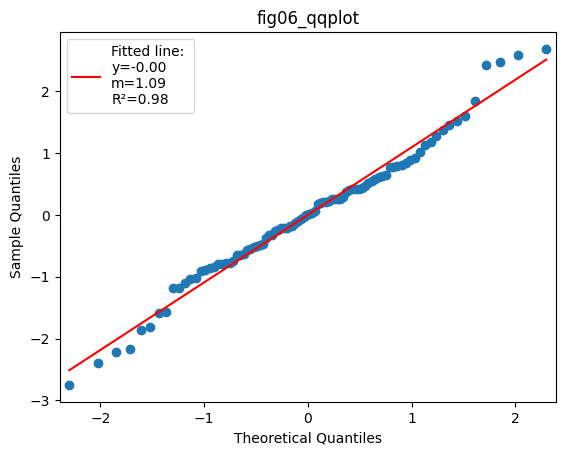

k =  None
The data is NOT normally distributed. p-value: 3.1540481775360316e-08


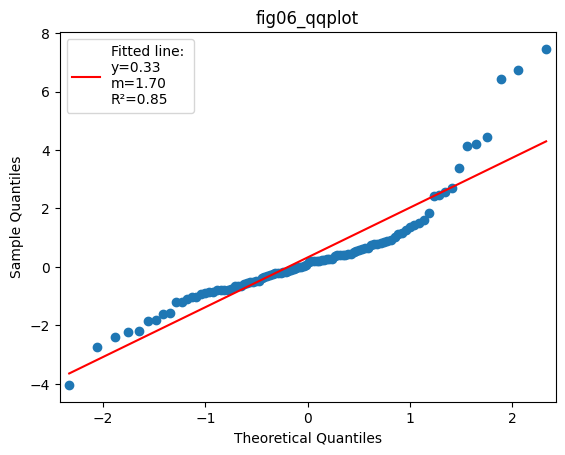

In [13]:
from utils import funs_gp_evaluation
import matplotlib.pyplot as plt

for k in [1.5, None]:  # outlier detection threshold
    print("k = ", k)
    pval = funs_gp_evaluation.test_normality(y_tilde, k)
    slope, intercept, r2 = funs_gp_evaluation.make_qqplot(y_tilde, k, MAKEPLOT=True)
    plt.title("fig06_qqplot")
    plt.show()

In [14]:
data = funs_data_processing.load_data(PROCESSED_TEST_FILE)
data = data.astype(np.float64)
data["y"] = y
data["y_hat"] = y_hat
data["res"] = y - y_hat
data["ares"] = np.abs(y - y_hat)
data["nres"] = y_tilde
data["anres"] = np.abs(y_tilde)
data.head()

%eval_id  RELDEPTH  DIAMETER      ANGLE  ELECTRELDEPTH  THICKNESS_SKIN  \
0       1.0  0.533184  0.982384  38.264292       0.720695        0.314840   
1       2.0  0.306564  0.395196  81.781101       0.513030        0.742492   
2       3.0  0.902587  0.142919  29.387003       0.355970        0.694648   
3       4.0  0.439308  0.162354   0.176215       0.597264        0.806864   
4       5.0  0.218923  0.739704  32.296004       0.159155        0.419819   

   THICKNESS_SCT  THICKNESS_APONEUROSIS  THICKNESS_LOOSE_AREOLAR_TISSUE  \
0       0.420981               0.260275                        0.267550   
1       1.466955               0.177922                        0.532739   
2       1.821147               0.167004                        0.621504   
3       1.707275               0.447387                        0.971124   
4       0.908649               0.461563                        0.321421   

   THICKNESS_SKULL_OUTER  ...  CONDUCTIVITY_LOOSE_AREOLAR_TISSUE  \
0               1.107365  ...                           0.016609   
1               0.645591  ...                           0.117563   
2               2.063564  ...                           0.083764   
3               1.854619  ...                           0.118749   
4               2.269861  ...                           0.046291   

   CONDUCTIVITY_SKULL_CORTICAL  CONDUCTIVITY_SKULL_DIPLOE  CONDUCTIVITY_CSF  \
0                     0.004684                   0.009933          1.407356   
1                     0.013195                   0.289143          3.584140   
2                     0.001628                   0.265654          1.791546   
3                     0.011695                   0.069417          1.002941   
4                     0.007071                   0.252808          1.906350   

           y      y_hat       res      ares      nres     anres  
0  33.813167  27.335173  6.477994  6.477994  2.683754  2.683754  
1  12.681425  15.007291 -2.325866  2.325866 -0.654863  0.654863  
2  21.327639  20.895900  0.431738  0.431738  0.248460  0.248460  
3  11.295077   9.293488  2.001588  2.001588  0.769178  0.769178  
4  21.660863  20.016683  1.644180  1.644180  1.378144  1.378144  

[5 rows x 26 columns]

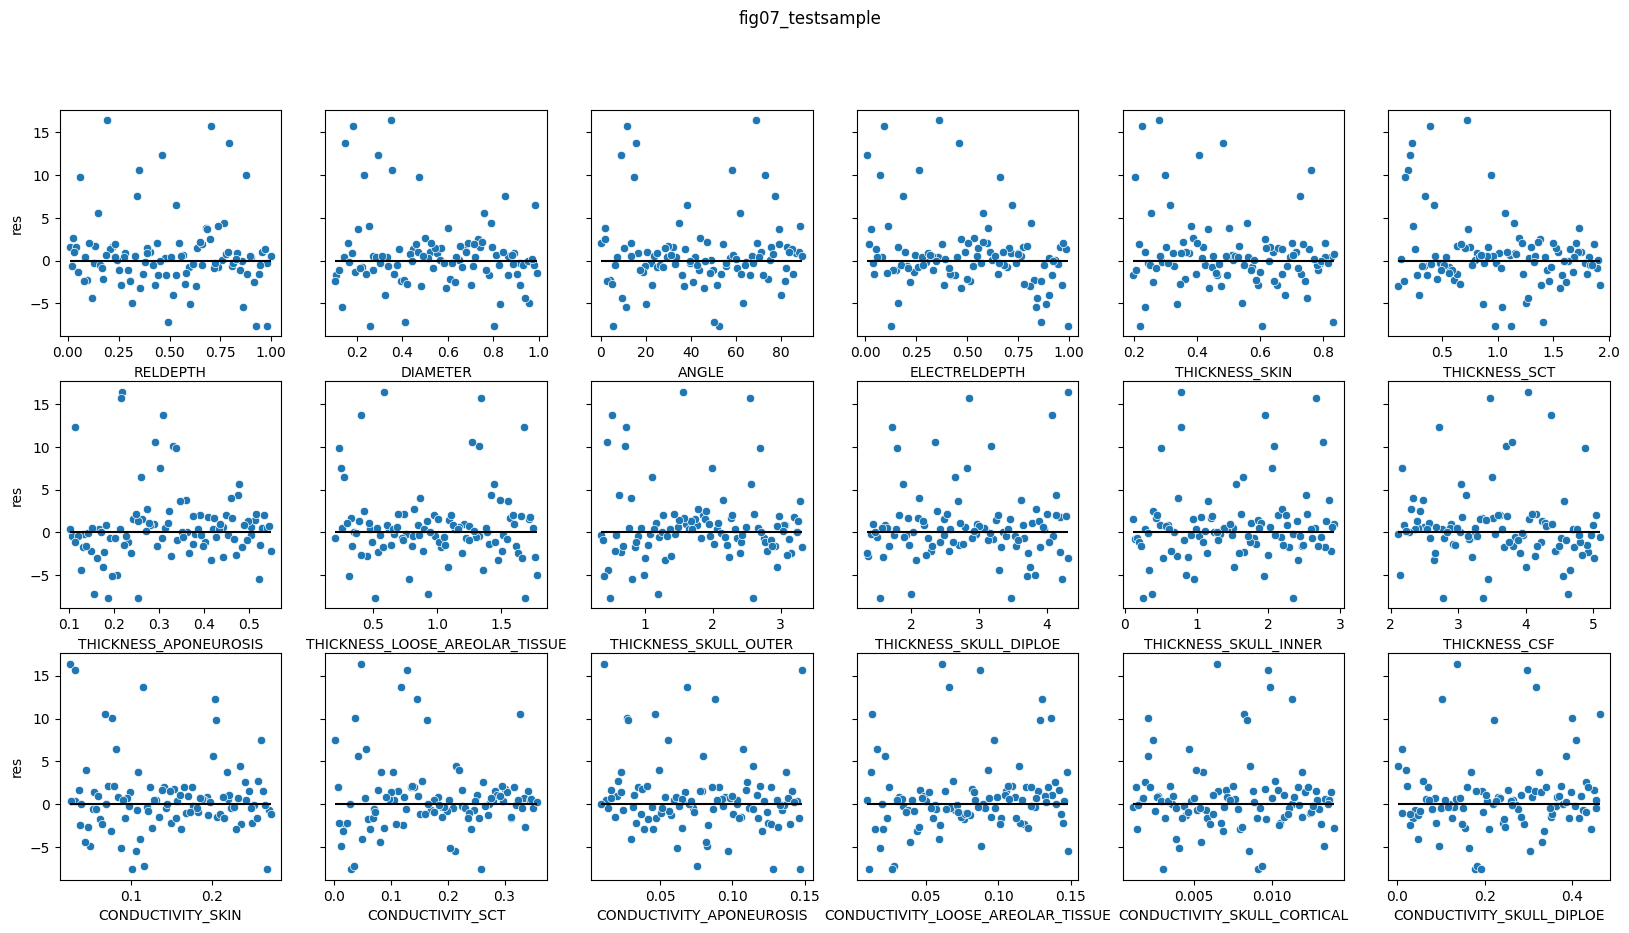

In [15]:
title = "fig07_testsample"

fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
axs: List[plt.Axes] = axs.flatten()
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="res", ax=ax)
    ax.set_xlabel(c)
    ax.hlines(0.0, data[c].min(), data[c].max(), color="black")
plt.suptitle(title)
plt.show()

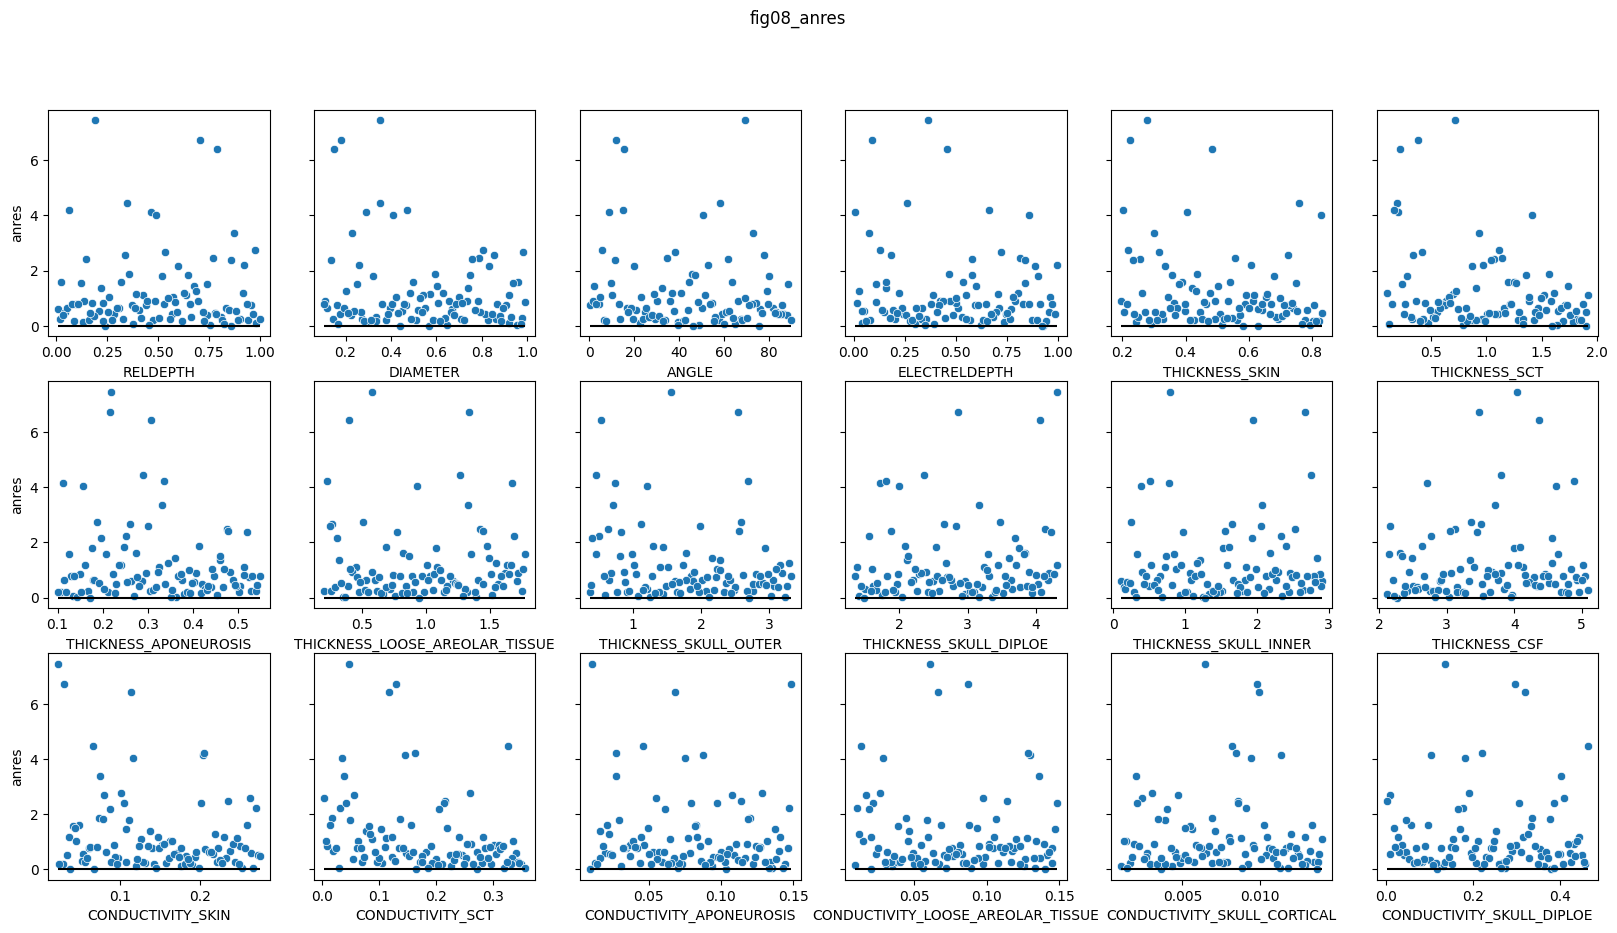

In [16]:
title = "fig08_anres"

fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
axs: List[plt.Axes] = axs.flatten()
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="anres", ax=ax)
    ax.set_xlabel(c)
    ax.hlines(0.0, data[c].min(), data[c].max(), color="black")
plt.suptitle(title)
plt.show()

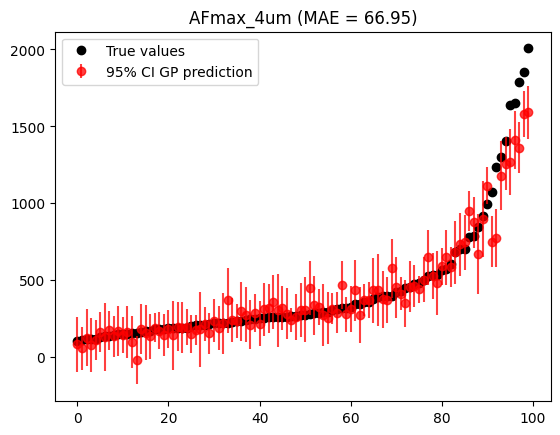

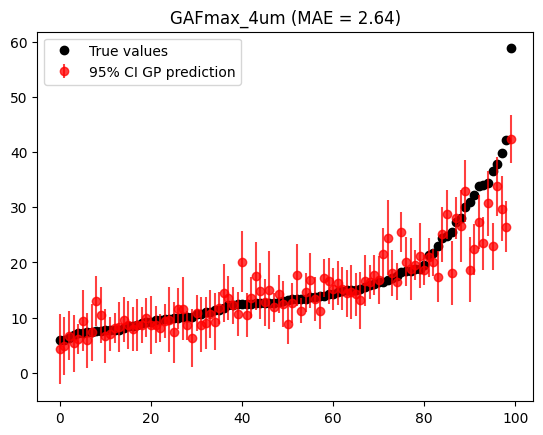

In [20]:
def plot_prediction_vs_truth(RESPONSE):
    y = funs_data_processing.get_results(TEST_SAMPLES_FILE, RESPONSE)
    y_hat = funs_data_processing.get_results(tmp_folder / "predictions.dat", RESPONSE)
    std = np.sqrt(
        funs_data_processing.get_results(
            tmp_folder / "variances.dat", RESPONSE + "_variance"
        )
    )
    y_tilde = (y - y_hat) / std

    sorted_idx = np.argsort(y)
    y = y[sorted_idx]
    y_hat = y_hat[sorted_idx]
    std = std[sorted_idx]
    plt.plot(y, "ko", label="True values")
    plt.errorbar(
        range(len(y_hat)),
        y_hat,
        yerr=2 * std,
        fmt="o",
        color="red",
        alpha=0.75,
        label="95% CI GP prediction",
    )
    # plt.ylim(-200, 1420)
    plt.legend()
    plt.title(f"{RESPONSE} (MAE = {np.mean(np.abs(y - y_hat)):.2f})")
    plt.show()


plot_prediction_vs_truth("AFmax_4um")
plot_prediction_vs_truth("GAFmax_4um")